In [3]:
import kagglehub
import json
import cv2
#from google.colab.patches import cv2_imshow
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

In [ ]:
path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")
print("Path to dataset files:", path)

In [ ]:
#!mkdir C:\Users\tyler\content\brain_tumor_dataset
#!robocopy C:\Users\tyler\.cache\kagglehub\datasets\pkdarabi\ C:\Users\tyler\content\brain_tumor_dataset /e
print("already done")

In [5]:
image = cv2.imread(r"C:\Users\tyler\.cache\kagglehub\datasets\pkdarabi\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg")
print(image.shape)
print(type(image))
window_name = 'image'

# Displaying the image
cv2.imshow(window_name, image)

# waits for user to press any key
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()

(640, 640, 3)
<class 'numpy.ndarray'>


In [ ]:
with open(r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\_annotations.coco.json", 'r') as file:
    data = json.load(file)
data.keys()

data['annotations'][1380]
#print(data['images'][0]['file_name'])

In [ ]:
data['images'][1380]

In [6]:
# Paths
annotationPath = r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\_annotations.coco.json"
imagesDir = r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train"

#Specify ID of image
singleImageID = 10

# Load COCO annotations
cocoAnnotations = COCO(annotationPath)

# Load single image info and read the image
imgInfo = cocoAnnotations.loadImgs(singleImageID)[0]
imgPath = imagesDir + '/' + imgInfo['file_name']
print(f'Path of image selected -- {imgPath}')
img = cv2.imread(imagesDir + '/' + imgInfo['file_name'])
height, width = image.shape[:2]
print(f'Image dimensions -- {height} x {width}')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Path of image selected -- C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train/2433_jpg.rf.3cdf8e4cb3a08e9b2fccc6c6082c2344.jpg
Image dimensions -- 640 x 640


In [ ]:
# Initiate an empty mask
mask = np.zeros((height, width), dtype=np.uint8)

# Get all annotations for the specified image (generally images can have multiple annotations)
annotationID = cocoAnnotations.getAnnIds(imgIds=singleImageID)
annotation = cocoAnnotations.loadAnns(annotationID)

annotation[0]['segmentation']
print(annotation)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Path of image selected -- C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train/1942_jpg.rf.d75d893faec6ebb3ef8d20326802e385.jpg
Image dimensions -- 640 x 640


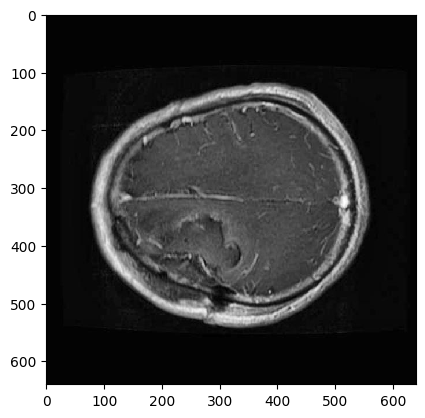

[0, 1, 2]
400
[{'id': 400, 'image_id': 400, 'category_id': 1, 'bbox': [171, 323, 185, 163.75], 'area': 30293.75, 'segmentation': [[356.25, 322.5, 171.25, 322.5, 171.25, 486.25, 356.25, 486.25, 356.25, 322.5]], 'iscrowd': 0}]


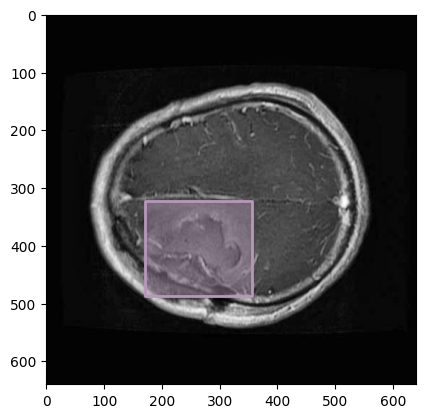

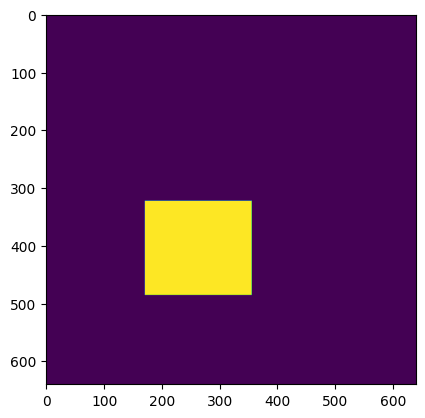

In [11]:

# Paths
annotationPath = r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\_annotations.coco.json"
imagesDir = r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train"

# Specify ID of image
singleImageID = 400

# Load COCO annotations
cocoAnnotations = COCO(annotationPath)

# Load single image info and read the image
imgInfo = cocoAnnotations.loadImgs(singleImageID)[0]
imgPath = imagesDir + '/' + imgInfo['file_name']
print(f'Path of image selected -- {imgPath}')
img = cv2.imread(imagesDir + '/' + imgInfo['file_name'])
height, width = image.shape[:2]
print(f'Image dimensions -- {height} x {width}')

# plot unannotated image
image = np.array(Image.open(imgPath))
plt.imshow(image, interpolation='nearest')
plt.show()

# plot annotations on image
plt.imshow(image)
cat_ids = cocoAnnotations.getCatIds()
print(cat_ids)
anns_ids = singleImageID
print(anns_ids)
anns = cocoAnnotations.loadAnns(anns_ids)
print(anns)
cocoAnnotations.showAnns(anns)
plt.show()

# create mask from annotations
mask = cocoAnnotations.annToMask(anns[0])

for i in range(len(anns)):
    mask += cocoAnnotations.annToMask(anns[i])

plt.imshow(mask)
plt.show()

In [ ]:
import pathlib
annotationPath = r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\_annotations.coco.json"
train_dir = pathlib.Path(r"C:/Users/tyler/content/brain_tumor_dataset/brain-tumor-image-dataset-semantic-segmentation/versions/1/train/")
val_dir = pathlib.Path(r"C:/Users/tyler/content/brain_tumor_dataset/brain-tumor-image-dataset-semantic-segmentation/versions/1/valid/")
images = list(train_dir.glob('**/*.jpg'))
image_count = len(images)

coco = COCO(annotationPath)

train_ds = tf.data.Dataset.list_files(str(train_dir)+"/*.jpg", shuffle=False)
val_ds = tf.data.Dataset.list_files(str(val_dir)+"/*.jpg", shuffle=False)


print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


def build_masks(paths, coco):
    with open(r"C:\Users\tyler\content\brain_tumor_dataset\brain-tumor-image-dataset-semantic-segmentation\versions\1\train\_annotations.coco.json", 'r') as file:
        data = json.load(file)

    mask_ds = []
    for i in range(len(paths)):
        image = np.array(Image.open(paths[i]))

        ID = get_id_from_path(data, str(paths[i]))
        print("=",i,"=", end='',sep='')
        cat_ids = coco.getCatIds()
        anns_ids = coco.getAnnIds(imgIds=ID, catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)

        mask = coco.annToMask(anns[0])
        for j in range(len(anns)):
            mask += coco.annToMask(anns[j])

        mask_ds.append(mask)

    return tf.data.Dataset.from_tensor_slices(mask_ds)

        

        
def get_id_from_path(data, path):
    for i in data['images']:
        #print(str(train_dir) + "\\"+i['file_name'], "\n", path, sep='')
        if str(train_dir) + "\\"+i['file_name'] == path:
            return i['id']

    return None


build_masks(images, coco)